# **Import library and Mount drive**

In [1]:
!apt-get install -y libsndfile1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
!pip install pydub
!pip install xgboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
import catboost as cb
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score

import lightgbm as lgb
import tensorflow as tf
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import librosa
import os
from pydub import AudioSegment
import librosa.display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Turn all Audio file to 3 second long**

In [25]:
main_dir = '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24'

In [ ]:
def cut_audio_to_3s(input_folder):
    for folder_name in os.listdir(main_dir):
        folder_path = os.path.join(main_dir, folder_name)
        # Iterate through each audio file in the subfolder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav') or file_name.endswith('.mp3'):
                # Load the audio file
                input_path = os.path.join(folder_path, file_name)
                try:
                    audio = AudioSegment.from_file(input_path)
                    if len(audio) < 3000:
                        silence_duration = 3000 - len(audio)
                        silence = AudioSegment.silent(duration=silence_duration)
                        three_sec_audio = audio + silence
                    else:
                        # Truncate the audio to 3 seconds
                        three_sec_audio = audio[:3000]

                    # Save the 3-second audio to the output folder
                    three_sec_audio.export(input_path, format="wav")

                except Exception as e:
                    print(f"Error processing file: {input_path}")
                    print(e)
                    # Use ffmpeg to get more detailed information
                    result = subprocess.run(['ffmpeg', '-i', input_path], stderr=subprocess.PIPE)
                    print(result.stderr.decode('utf-8'))  # Print ffmpeg's error output

cut_audio_to_3s(main_dir)

# **Take sound data from folder**

In [26]:
def label_from_folder(file_name):
    string = file_name
    # Split the string by hyphen
    numbers = string.split('-')
    # Access the third number (index 2)
    third_number = numbers[2]

    if '01' in third_number:
        return 'Neutral'
    elif '02' in third_number:
        return 'Calm'
    elif '03' in third_number:
        return 'Happy'
    elif '04' in third_number:
        return 'Sad'
    elif '05' in third_number:
        return 'Angry'
    elif '06' in third_number:
        return 'Fearful'
    elif '07' in third_number:
        return 'Disgust'
    elif '08' in third_number:
        return 'Surprised'
    else:
        return 'Unknown'

# Dictionary to store file paths and their corresponding labels
data = {'file_path': [], 'label': []}

# Iterate through each subfolder
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    # Iterate through each audio file in the subfolder
    for file_name in os.listdir(folder_path):
      if file_name.endswith('.wav') or file_name.endswith('.mp3'):
        label = label_from_folder(file_name)
        file_path = os.path.join(folder_path, file_name)
        data['file_path'].append(file_path)
        data['label'].append(label)

# Convert to DataFrame
df = pd.DataFrame(data)

In [27]:
df

,file_path,label
0,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
1,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
2,/content/drive/MyDrive/Sound_Expression/audio_...,Neutral
3,/content/drive/MyDrive/Sound_Expression/audio_...,Calm
4,/content/drive/MyDrive/Sound_Expression/audio_...,Happy
...,...,...
1434,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1435,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1436,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised
1437,/content/drive/MyDrive/Sound_Expression/audio_...,Surprised


# **Save output CSV to folder And Plot example**

In [ ]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/audio_labels.csv'
df.to_csv(output_file_path, index=False)

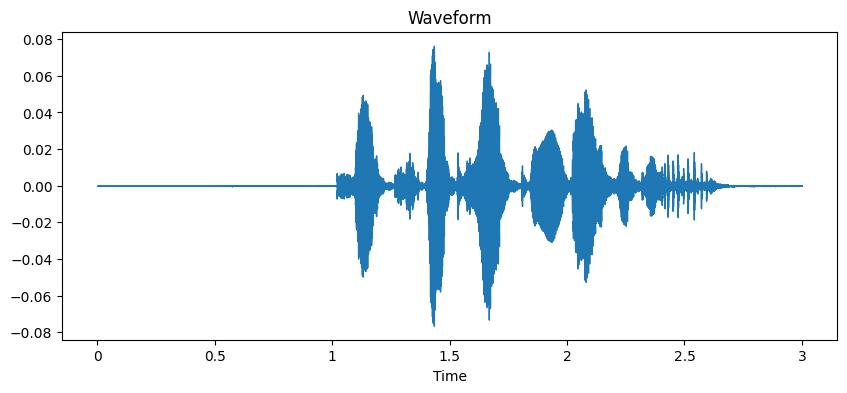

<ipython-input-22-efbc979e0c04>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


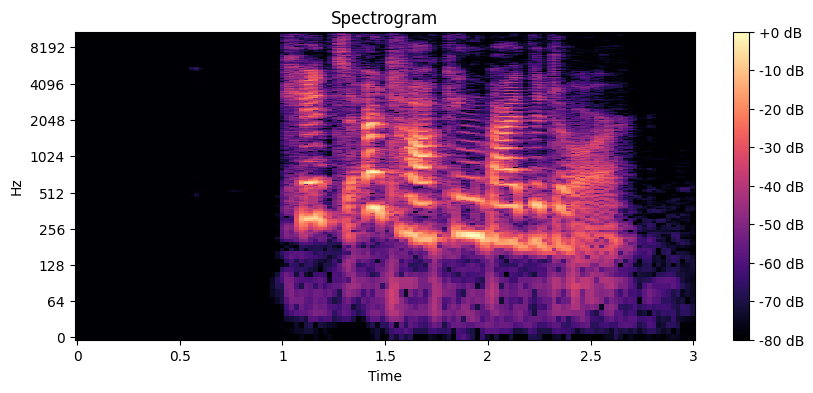

In [ ]:
# Load an example audio file
example_file = os.path.join(main_dir, '/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav')
y, sr = librosa.load(example_file)

# Display waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Display spectrogram
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# **Data Extraction**

In [13]:
# Function to extract MFCC features from an audio file
def extract_mfcc(file_path, n_mfcc=13):
    X, srr = librosa.load(file_path, sr=None)
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=srr, n_mfcc=n_mfcc).T, axis=0)
    # Extract delta and delta-delta coefficients
    mfcc_delta = librosa.feature.delta(mfccs)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(X)
    return mfccs, mfcc_delta, zero_crossing_rate

In [14]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs, mfcc_delta, zero_crossing_rate = extract_mfcc(sample, n_mfcc=13)
print(zero_crossing_rate.shape)
print(mfcc_delta.shape)
print(mfccs.shape)

(1, 282)
(13,)
(13,)


In [29]:
# Function to flatten MFCC, delta, and zero_crossing_rate features
def flatten_features(mfccs, mfcc_delta, zero_crossing_rate):
    mfccs=mfccs.flatten()
    mfcc_delta=mfcc_delta.flatten()
    zero_crossing_rate=zero_crossing_rate.flatten()
    # Concatenate and flatten the features
    combined_features = np.concatenate((mfccs, mfcc_delta, zero_crossing_rate), axis=0)
    flattened_features = combined_features.flatten()
    return flattened_features

In [30]:
sample="/content/drive/MyDrive/Sound_Expression/audio_speech_actors_01-24/Actor_24/03-01-01-01-01-02-24.wav"
mfccs, mfcc_delta, zero_crossing_rate = extract_mfcc(sample, n_mfcc=13)
m=flatten_features(mfccs, mfcc_delta, zero_crossing_rate)
print(m.shape)

(308,)


In [31]:
m

array([-6.89023376e+02,  7.32991180e+01, -1.24801350e+01,  4.78461933e+00,
       -6.15756559e+00,  1.92954987e-01, -1.54669981e+01, -3.81068635e+00,
       -1.37417479e+01, -1.01439238e+01, -5.45315456e+00, -6.43838310e+00,
       -8.01488781e+00,  4.09871941e+01,  4.09871941e+01,  4.09871941e+01,
        4.09871941e+01,  4.09871941e+01, -6.06761742e+00, -5.97495198e-01,
       -1.02878809e+00, -2.27147564e-01, -2.27147564e-01, -2.27147564e-01,
       -2.27147564e-01, -2.27147564e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [33]:
output_file_path = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
m=np.zeros((1439,308))
df2=pd.DataFrame(m)
df2.to_csv(output_file_path, index=False)

In [34]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,298,299,300,301,302,303,304,305,306,307
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
def extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=13, max_length=308):
    with open(output_csv, 'w') as f:
        # Write header
        header = ['File'] + [f'Feature_{i}' for i in range(max_length)] + ['Label']
        f.write(','.join(header) + '\n')

        for i, file_path in enumerate(file_paths):
            # Extract features
            mfccs, mfcc_delta, zero_crossing_rate = extract_mfcc(file_path, n_mfcc=n_mfcc)
            flattened_features = flatten_features(mfccs, mfcc_delta, zero_crossing_rate)
            label = labels[i]

            # Write row
            row = [f'File_{i}'] + flattened_features.tolist() + [label]
            f.write(','.join(map(str, row)) + '\n')

file_paths = df.iloc[:, 0].values
labels = df.iloc[:, -1].values
output_csv = '/content/drive/MyDrive/Sound_Expression/features_extraction.csv'
extract_features_to_csv(file_paths, labels, output_csv, n_mfcc=13, max_length=308)

In [36]:
df5=pd.read_csv('/content/drive/MyDrive/Sound_Expression/features_extraction.csv')

In [37]:
df5.head()

,File,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_299,Feature_300,Feature_301,Feature_302,Feature_303,Feature_304,Feature_305,Feature_306,Feature_307,Label
0,File_0,-700.773865,66.382896,-15.758940,12.378655,-2.779428,2.040216,-16.535204,-0.088404,-11.130050,...,0.090332,0.096680,0.088379,0.082031,0.066406,0.055664,0.061035,0.045898,0.038086,Neutral
1,File_1,-839.049072,55.327892,-5.580369,17.065022,-2.285673,4.670846,-9.527437,0.471413,-10.288007,...,0.011719,0.021484,0.014648,0.017578,0.014648,0.010742,0.011719,0.011719,0.010742,Calm
2,File_2,-704.830444,59.737812,-10.804083,12.701001,-4.340371,4.029755,-15.786472,0.224078,-13.418604,...,0.068848,0.071289,0.082031,0.077148,0.083008,0.070312,0.065430,0.048828,0.027344,Neutral
3,File_3,-787.132324,59.854774,-5.291254,18.932837,-4.991405,8.691060,-11.437882,0.346917,-10.680456,...,0.028809,0.036133,0.033203,0.028320,0.032227,0.018555,0.025391,0.013672,0.009766,Calm
4,File_4,-572.794189,63.435452,-17.273922,4.787413,-2.719662,-1.173190,-17.083836,-2.993031,-10.746663,...,0.120117,0.093750,0.103516,0.082031,0.070312,0.095703,0.104492,0.085938,0.057617,Happy


In [40]:
y=df5.iloc[:,-1]

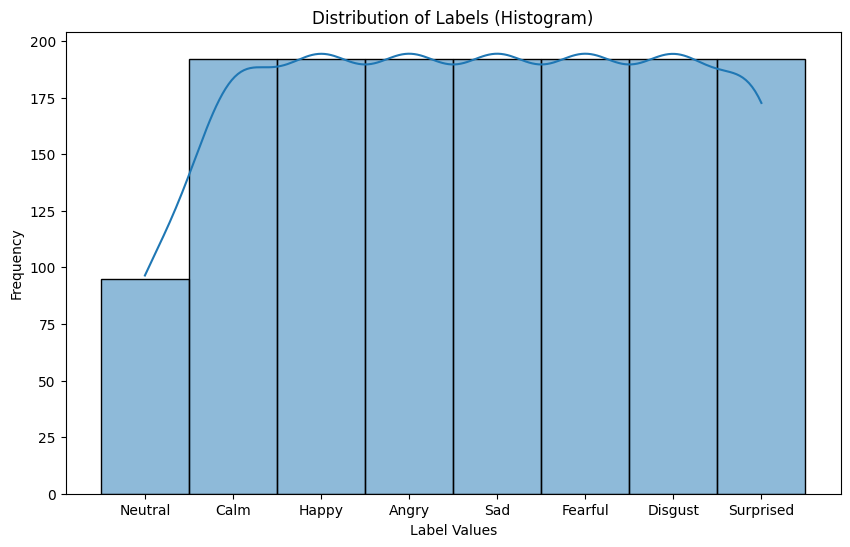

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

# **Others Features we can considered when the model are not satisfy**

# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)


In [ ]:
# Load audio file
# y, sr = librosa.load('your_audio_file.wav', sr=None)

# Extract MFCCs
# mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Extract delta and delta-delta coefficients
# mfcc_delta = librosa.feature.delta(mfcc)
# mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# Extract chroma features
# chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Extract spectral contrast
# spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# Extract spectral centroid
# spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

# Extract zero-crossing rate
# zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

# Extract root mean square energy
# rms = librosa.feature.rms(y=y)

# Extract mel spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Combine all features
# features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2, chroma, spectral_contrast,
#                            spectral_centroid, zero_crossing_rate, rms, mel_spectrogram), axis=0)

# Shape of features
# print("Shape of combined features: ", features.shape)

# **Split data frame to smaller data (X,y)**

In [42]:
X=df5.iloc[:,1:-1]
y=df5.iloc[:,-1]

In [43]:
# Encode string class values as integers to avoid errors in newer versions of XGBoost
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y = label_encoder.transform(y)

In [44]:
X=np.array(X)
y=np.array(y)

In [45]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

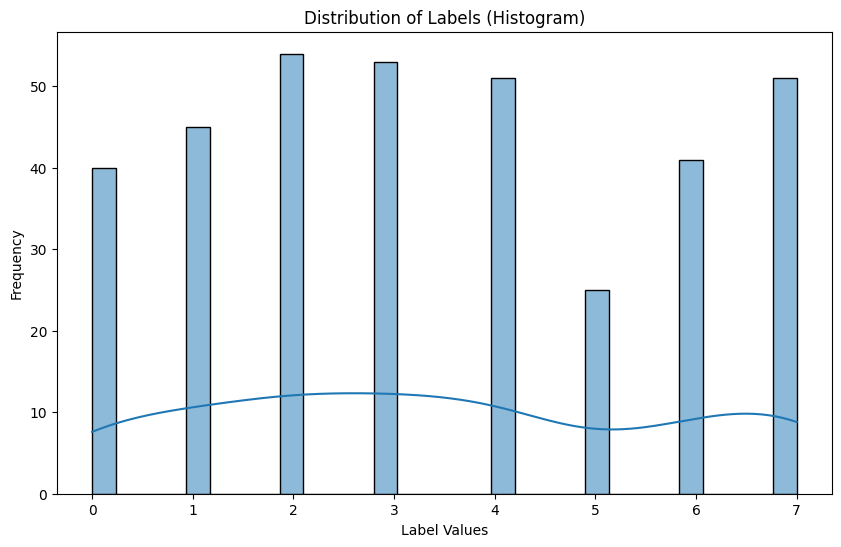

In [46]:
# Giả sử labels của bạn nằm trong biến 'labels'
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

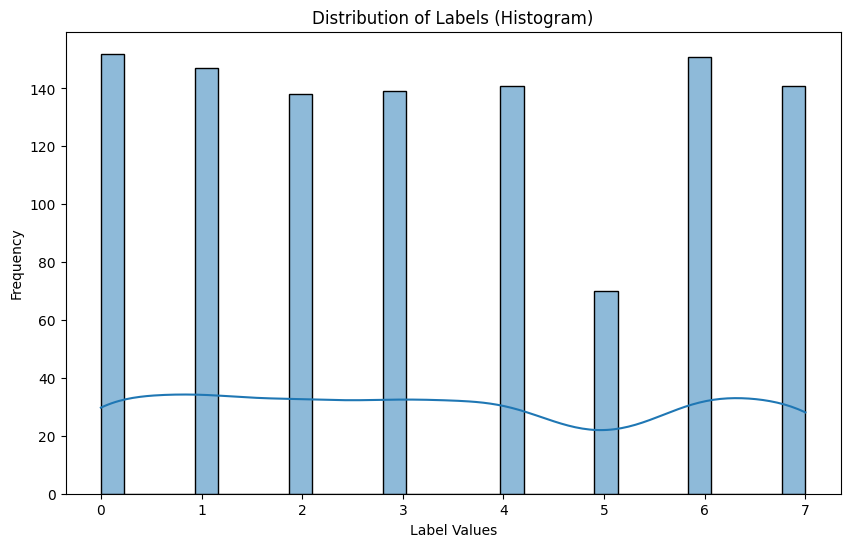

In [47]:
# Giả sử labels của bạn nằm trong biến 'labels'
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Distribution of Labels (Histogram)')
plt.show()

In [48]:
print(X.shape)
print(y.shape)
print(X[1,-1])

(1439, 308)
(1439,)
0.0107421875


## **Using XGBoost**

In [75]:
# Create the DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [76]:
params = {
    'objective': 'multi:softprob',
    'max_depth': 15,
    'learning_rate': 0.01,
    'eta': 0.3,
    'eval_metric': 'logloss',
    'num_class':8
}

In [77]:
# Train the model
bst = xgb.train(params, dtrain, num_boost_round=200, )

In [78]:
# Make predictions
y_pred_prob = bst.predict(dtest)
y_pred = [int(np.argmax(line)) for line in y_pred_prob]  # Convert probabilities to class predictions

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.49


In [80]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='macro')  # Use 'micro' or 'weighted' as needed
recall = recall_score(y_test, y_pred, average='macro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Precision: 0.47
Recall: 0.47


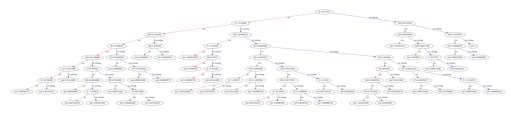

In [55]:
xgb.plot_tree(bst, num_trees=0)
plt.show()

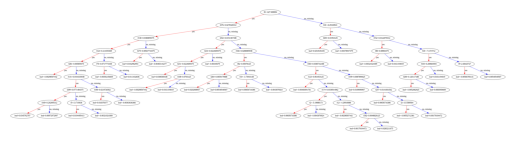

In [56]:
xgb.plot_tree(bst, num_trees=1)
plt.show()

## **Using LightGBM**

In [57]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

In [58]:
# train
gbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.01, n_estimators=200)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="l1", callbacks=[lgb.early_stopping(5)])

print("Starting predicting...")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71019
[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 308
[LightGBM] [Info] Start training from score 3.379981
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's l1: 1.67431	valid_0's l2: 4.02151
Starting predicting...


In [59]:
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"The RMSE of prediction is: {rmse_test}")

# feature importances
print(f"Feature importances: {list(gbm.feature_importances_)}")

The RMSE of prediction is: 2.005369157398473
Feature importances: [156, 18, 81, 37, 91, 69, 18, 136, 130, 50, 25, 32, 80, 48, 0, 0, 0, 0, 24, 23, 55, 39, 0, 0, 0, 0, 39, 7, 1, 16, 6, 9, 7, 17, 11, 15, 4, 2, 3, 36, 14, 6, 3, 3, 4, 7, 24, 9, 2, 12, 6, 15, 6, 18, 9, 10, 14, 7, 6, 2, 4, 2, 2, 8, 11, 4, 12, 3, 0, 7, 7, 12, 14, 6, 2, 10, 15, 7, 4, 16, 29, 3, 12, 34, 22, 11, 24, 15, 6, 9, 8, 6, 3, 9, 27, 9, 20, 4, 18, 7, 11, 6, 15, 7, 14, 5, 15, 6, 9, 17, 38, 8, 6, 5, 25, 21, 12, 3, 9, 38, 3, 12, 12, 18, 10, 20, 44, 6, 20, 15, 15, 16, 2, 14, 6, 7, 40, 40, 23, 17, 11, 18, 17, 27, 23, 5, 25, 14, 27, 21, 5, 14, 7, 13, 11, 27, 33, 33, 15, 14, 11, 12, 8, 28, 3, 17, 19, 16, 13, 6, 12, 26, 81, 11, 21, 22, 41, 23, 14, 13, 22, 12, 36, 13, 24, 12, 49, 33, 15, 30, 17, 51, 45, 1, 15, 27, 28, 34, 17, 9, 70, 20, 50, 46, 9, 19, 19, 41, 16, 54, 84, 19, 22, 17, 16, 24, 25, 60, 44, 14, 14, 10, 26, 12, 14, 19, 11, 10, 20, 21, 26, 39, 95, 6, 11, 23, 20, 13, 41, 12, 19, 17, 22, 12, 2, 14, 17, 24, 14, 19, 8, 33, 1

In [60]:
def rmsle(y_true, y_pred):
    return "RMSLE", np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print("Starting training with custom eval function...")
# train
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=rmsle, callbacks=[lgb.early_stopping(5)])

Starting training with custom eval function...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71019
[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 308
[LightGBM] [Info] Start training from score 3.379981
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 4.02151	valid_0's RMSLE: 0.564337


LGBMRegressor(learning_rate=0.01, n_estimators=200)

In [61]:
# another self-defined eval metric
# f(y_true: array, y_pred: array) -> name: str, eval_result: float, is_higher_better: bool
# Relative Absolute Error (RAE)
def rae(y_true, y_pred):
    return "RAE", np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False


print("Starting training with multiple custom eval functions...")
# train
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=[rmsle, rae], callbacks=[lgb.early_stopping(5)])

print("Starting predicting...")

Starting training with multiple custom eval functions...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71019
[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 308
[LightGBM] [Info] Start training from score 3.379981
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 4.02151	valid_0's RMSLE: 0.564337	valid_0's RAE: 0.85748
Starting predicting...


In [62]:
# predict
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
y_pred = [int(np.argmax(line)) for line in y_pred_prob]
# eval
rmsle_test = rmsle(y_test, y_pred)[1]
rae_test = rae(y_test, y_pred)[1]
print(f"The RMSLE of prediction is: {rmsle_test}")
print(f"The RAE of prediction is: {rae_test}")

The RMSLE of prediction is: 1.4689316606027065
The RAE of prediction is: 1.7697268588770863


In [63]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'multiclass',
    'num_class': 8,
    'metric': 'multi_logloss'
}

model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71019
[LightGBM] [Info] Number of data points in the train set: 1079, number of used features: 308
[LightGBM] [Info] Start training from score -1.959909
[LightGBM] [Info] Start training from score -1.993357
[LightGBM] [Info] Start training from score -2.056536
[LightGBM] [Info] Start training from score -2.049316
[LightGBM] [Info] Start training from score -2.035030
[LightGBM] [Info] Start training from score -2.735295
[LightGBM] [Info] Start training from score -1.966510
[LightGBM] [Info] Start training from score -2.035030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [64]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)
y_pred_max = y_pred.argmax(axis=1)

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred_max)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5194444444444445


## **ANN 2 HiddenLayer**

In [65]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def grad_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def grad_relu(x):
    return np.where(x > 0, 1, 0)

def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

class ANN:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate=0.01):
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2. / hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2. / hidden_size2)
        self.b3 = np.zeros((1, output_size))
        self.learning_rate = learning_rate

    def feedforward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = relu(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = softmax(self.z3)

        return self.a3

    def backpropagate(self, X, y):
        m = y.shape[0]

        dz3 = self.a3 - y
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        dz2 = np.dot(dz3, self.W3.T) * grad_relu(self.z2)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * grad_relu(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            self.feedforward(X)
            self.backpropagate(X, y)
            if epoch % 100 == 0:
                loss = self.compute_loss(y)
                print(f'Epoch {epoch}, Loss: {loss}')

    def compute_loss(self, y):
      m = y.shape[0]
      epsilon = 1e-10  # Small value to avoid log(0)

      # Get the probabilities of the correct classes
      correct_class_probs = self.a3[range(m), np.argmax(y, axis=1)]

      # Add epsilon to avoid log(0)
      logprobs = -np.log(correct_class_probs + epsilon)

      # Compute average loss
      loss = np.sum(logprobs) / m
      return loss

    def predict(self, X):
        a3 = self.feedforward(X)
        return np.argmax(a3, axis=1)

In [66]:
def one_hot_encode(y, num_classes):
  one_hot = np.zeros((y.size, num_classes))
  one_hot[np.arange(y.size), y] = 1
  return one_hot

In [68]:
X_train.shape

(1079, 308)

In [69]:
y_train_one_hot = one_hot_encode(y_train, num_classes=8)

ann = ANN(input_size=308, hidden_size1=128, hidden_size2=256, output_size=8)
ann.train(X_train, y_train_one_hot, epochs=1000)

Epoch 0, Loss: 17.77524452628397
Epoch 100, Loss: 2.0749513932456836
Epoch 200, Loss: 2.0716518358601363
Epoch 300, Loss: 2.0691064559376913
Epoch 400, Loss: 2.0671187693896163
Epoch 500, Loss: 2.06554980901701
Epoch 600, Loss: 2.064300324079351
Epoch 700, Loss: 2.0632984494124442
Epoch 800, Loss: 2.0624895582630103
Epoch 900, Loss: 2.0618327539829053


## **DNN**

In [84]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [88]:
# Tạo TensorDataset cho tập train và test
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Tạo DataLoader cho tập train và test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [89]:
class FiveLayerANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5,output_size):
        super(FiveLayerANN, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, output_size)

        # Define the activation function
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.softmax(self.fc6(x))
        return x

In [90]:
# Define model parameters
input_size = 308
hidden_size1 = 128
hidden_size2 = 256
hidden_size3 = 128
hidden_size4 = 64
hidden_size5 = 32
output_size = 8

# Instantiate the model
model = FiveLayerANN(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [91]:
train_losses = []
test_losses = []

num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Tính toán test loss cho epoch này
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():  # Không tính toán gradient
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

    avg_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch [1/1000], Train Loss: 2.0761, Test Loss: 2.0815
Epoch [2/1000], Train Loss: 2.0701, Test Loss: 2.0733
Epoch [3/1000], Train Loss: 2.0564, Test Loss: 2.0589
Epoch [4/1000], Train Loss: 2.0326, Test Loss: 2.0517
Epoch [5/1000], Train Loss: 2.0224, Test Loss: 2.0474
Epoch [6/1000], Train Loss: 2.0156, Test Loss: 2.0373
Epoch [7/1000], Train Loss: 2.0095, Test Loss: 2.0257
Epoch [8/1000], Train Loss: 2.0072, Test Loss: 2.0384
Epoch [9/1000], Train Loss: 2.0120, Test Loss: 2.0258
Epoch [10/1000], Train Loss: 1.9979, Test Loss: 2.0057
Epoch [11/1000], Train Loss: 2.0008, Test Loss: 2.0105
Epoch [12/1000], Train Loss: 1.9913, Test Loss: 1.9973
Epoch [13/1000], Train Loss: 1.9812, Test Loss: 2.0197
Epoch [14/1000], Train Loss: 1.9806, Test Loss: 1.9817
Epoch [15/1000], Train Loss: 1.9835, Test Loss: 2.0203
Epoch [16/1000], Train Loss: 1.9797, Test Loss: 1.9668
Epoch [17/1000], Train Loss: 1.9620, Test Loss: 1.9591
Epoch [18/1000], Train Loss: 1.9523, Test Loss: 1.9603
Epoch [19/1000], Tr

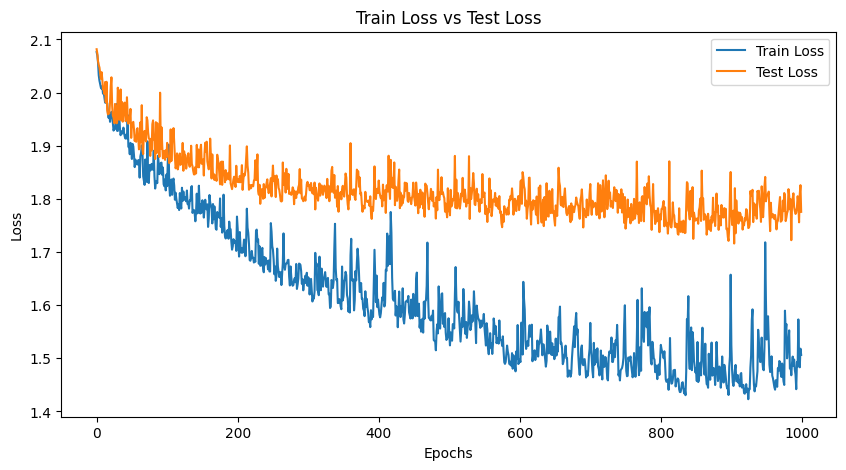

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

In [94]:
def accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

# Calculate accuracy on the training set
train_accuracy = accuracy(model, train_loader)
print(f'Training Accuracy: {train_accuracy:.2%}')

Training Accuracy: 79.80%
